# Imports

In [1]:
from google.colab import drive # comment out if not using Google Colab for model training and GPU access
drive.mount('/content/drive') # idem

%cd /content/drive/MyDrive/chestxray-efficientnet/

import os
import yaml
import copy
import random
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader

from src.data.download import ensure_data_dirs
from src.data.dataset import prepare_dataset_train, prepare_dataset_test

import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive
/content/drive/MyDrive/chestxray-efficientnet


In [2]:
# install requirements from requirements.txt
!pip install -r requirements.txt

with open("configs/default.yaml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg_data = cfg["data"]

# Loading data and building the datasets

In [3]:
cfg

{'model': {'name': 'efficientnet_b2', 'pretrained': True, 'num_classes': 3},
 'data': {'data_dir': 'data',
  'train_csv': 'data/train.csv',
  'img_size': 260,
  'batch_size': 32,
  'num_workers': 8,
  'val_size': 0.15,
  'random_state': 42,
  'dropbox_train_tar': 'https://www.dropbox.com/s/feaakvusdvkep3n/train.tar',
  'dropbox_train_csv': 'https://www.dropbox.com/s/9kebfecemhfkj7k/train.csv',
  'dropbox_test_tar': 'https://www.dropbox.com/s/20d8b9z8znc2lmp/testPublic.tar',
  'suffix': '?dl=1'},
 'training': {'epochs': 20,
  'lr': '1e-4',
  'weight_decay': '1e-5',
  'early_stopping_patience': 5,
  'device': 'cuda'},
 'paths': {'output_dir': 'outputs'}}

The following cell will only load the data from the competition dropbox if necessary.

In [ ]:
# ensure_data_dirs(cfg_data) # if data folders (train or test) are empty

Downaloading train data directory...
⬇️  Downloading from: https://www.dropbox.com/s/feaakvusdvkep3n/train.tar?dl=1
   Saved to: data/train.tar
📦 Extracting data/train.tar → data ...
   Extraction completed.
⬇️  Downloading from: https://www.dropbox.com/s/9kebfecemhfkj7k/train.csv?dl=1
   Saved to: data/train.csv
✅ Training data and train.csv downloaded.
Downaloading test data directory...
⬇️  Downloading from: https://www.dropbox.com/s/20d8b9z8znc2lmp/testPublic.tar?dl=1
   Saved to: data/test.tar
📦 Extracting data/test.tar → data ...
   Extraction completed.
✅ Test data downloaded.


In [ ]:
ensure_data_dirs(cfg_data) # otherwise

✔ data/train already populated and train.csv found.
✔ data/test already populated.


Then, we need to set up the config information to tell our pipeline where to look for the data in our working directory

In [3]:
cfg_data["train_dir"] = "data/train"
cfg_data["test_dir"] = "data/testPublic"

Once set up is done, we can load the Pytorch datasets:
- Train data is loaded and splitted: 85% train /15% validation
- Test data is loaded

In [4]:
train_df, train_dataset, val_df, val_dataset = prepare_dataset_train(cfg_data)
test_df, test_dataset = prepare_dataset_test(cfg_data)
print()
print("Train samples :", len(train_df))
print("Val samples   :", len(val_df))
print("Test samples  :", len(test_dataset))


Train samples : 9035
Val samples   : 1595
Test samples  : 3544


Then, we look for class imbalance in the training and validation sets:

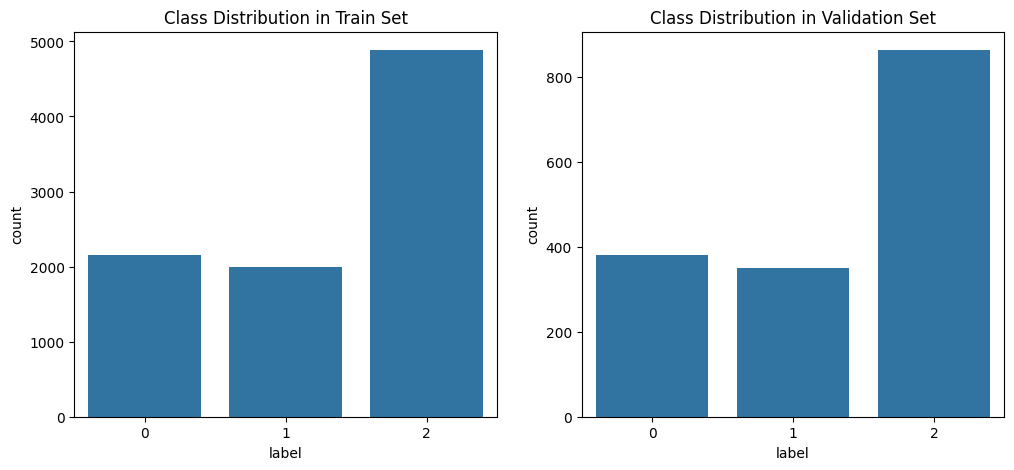

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.countplot(x=train_df["label"], ax=ax[0])
ax[0].set_title("Class Distribution in Train Set")
sns.countplot(x=val_df["label"], ax=ax[1])
ax[1].set_title("Class Distribution in Validation Set")
plt.show()

Clearly, there is some high level of class-imbalance in this dataset: Class 2 is way more represented than class 0 and 1. We also made sure to stratify against labels in the train/val split.

# Visualizing a few samples

In [ ]:
def show_samples(dataset, n=6):
    idxs = random.sample(range(len(dataset)), n)
    imgs = []
    labels = []

    for idx in idxs:
        img, label = dataset[idx]
        imgs.append(img.permute(1, 2, 0).numpy())
        labels.append(label)

    plt.figure(figsize=(12, 6))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

As this point, we look at the training and validation data to check that data processing was done correctly:

Train sample images:


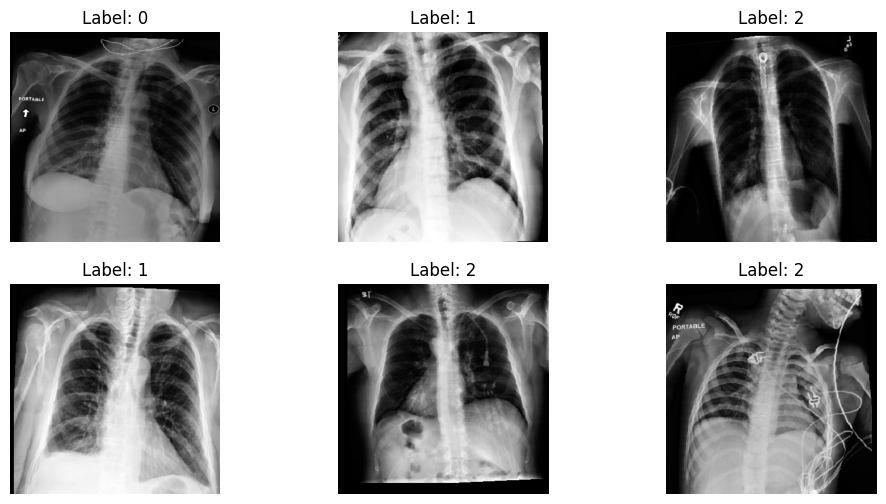


Validation sample images:


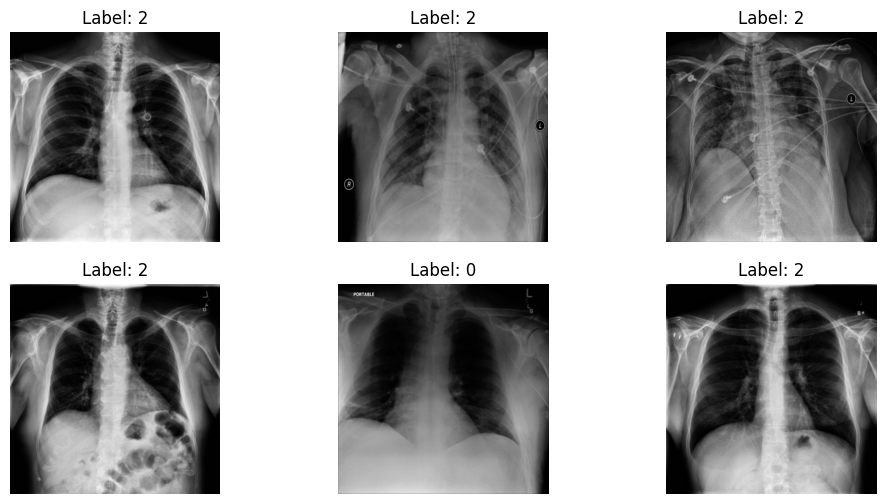

In [ ]:
print("Train sample images:")
show_samples(train_dataset)
print()
print("Validation sample images:")
show_samples(val_dataset)

# Model training

In [5]:
cfg["data"]

{'data_dir': 'data',
 'train_csv': 'data/train.csv',
 'img_size': 380,
 'batch_size': 16,
 'num_workers': 8,
 'val_size': 0.15,
 'random_state': 42,
 'dropbox_train_tar': 'https://www.dropbox.com/s/feaakvusdvkep3n/train.tar',
 'dropbox_train_csv': 'https://www.dropbox.com/s/9kebfecemhfkj7k/train.csv',
 'dropbox_test_tar': 'https://www.dropbox.com/s/20d8b9z8znc2lmp/testPublic.tar',
 'suffix': '?dl=1',
 'train_dir': 'data/train',
 'test_dir': 'data/testPublic'}

In [6]:
from src.training.train import train
cfg["data"]["train_dir"] = "data/train"
history = train(cfg)

🚀 Training on: cuda


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]


===== Epoch 1/20 =====


Train Loss 3.4027 | Acc 0.4291 || Val Loss 2.4958 | Acc 0.5555
⭐ New best val_acc: 0.5555

===== Epoch 2/20 =====


Train Loss 2.6202 | Acc 0.5243 || Val Loss 2.2013 | Acc 0.6345
⭐ New best val_acc: 0.6345

===== Epoch 3/20 =====


Train Loss 2.2785 | Acc 0.5757 || Val Loss 2.0691 | Acc 0.6621
⭐ New best val_acc: 0.6621

===== Epoch 4/20 =====


Train Loss 2.1261 | Acc 0.6228 || Val Loss 1.9324 | Acc 0.6633
⭐ New best val_acc: 0.6633

===== Epoch 5/20 =====


Train Loss 1.9966 | Acc 0.6366 || Val Loss 1.9889 | Acc 0.6890
⭐ New best val_acc: 0.6890

===== Epoch 6/20 =====


Train Loss 1.9141 | Acc 0.6563 || Val Loss 1.7759 | Acc 0.6740
No improvement for 1 epoch(s).

===== Epoch 7/20 =====


Train Loss 1.8206 | Acc 0.6745 || Val Loss 1.7725 | Acc 0.7060
⭐ New best val_acc: 0.7060

===== Epoch 8/20 =====


Train Loss 1.7263 | Acc 0.6847 || Val Loss 1.7725 | Acc 0.7047
No improvement for 1 epoch(s).

===== Epoch 9/20 =====


Train Loss 1.6385 | Acc 0.7022 || Val Loss 1.8163 | Acc 0.7028
No improvement for 2 epoch(s).

===== Epoch 10/20 =====


Train Loss 1.5190 | Acc 0.7191 || Val Loss 1.7254 | Acc 0.7210
⭐ New best val_acc: 0.7210

===== Epoch 11/20 =====


Train Loss 1.4486 | Acc 0.7325 || Val Loss 1.7688 | Acc 0.7122
No improvement for 1 epoch(s).

===== Epoch 12/20 =====


Train Loss 1.3235 | Acc 0.7494 || Val Loss 1.7819 | Acc 0.7047
No improvement for 2 epoch(s).

===== Epoch 13/20 =====


Train Loss 1.2359 | Acc 0.7690 || Val Loss 1.8096 | Acc 0.7310
⭐ New best val_acc: 0.7310

===== Epoch 14/20 =====


Train Loss 1.1210 | Acc 0.7837 || Val Loss 1.8364 | Acc 0.7191
No improvement for 1 epoch(s).

===== Epoch 15/20 =====


Train Loss 1.0643 | Acc 0.7915 || Val Loss 1.8724 | Acc 0.7273
No improvement for 2 epoch(s).

===== Epoch 16/20 =====


Train Loss 0.9786 | Acc 0.8059 || Val Loss 1.9491 | Acc 0.7166
No improvement for 3 epoch(s).

===== Epoch 17/20 =====


Train Loss 0.8905 | Acc 0.8225 || Val Loss 1.9466 | Acc 0.7185
No improvement for 4 epoch(s).

===== Epoch 18/20 =====


Train Loss 0.8327 | Acc 0.8297 || Val Loss 2.0155 | Acc 0.7179
No improvement for 5 epoch(s).
⛔ Early stopping triggered.
✅ Best model saved at: outputs/model/efficientnet_b4_best.safetensors
📦 Last epoch model saved at: outputs/model/efficientnet_b4_last_epoch.safetensors


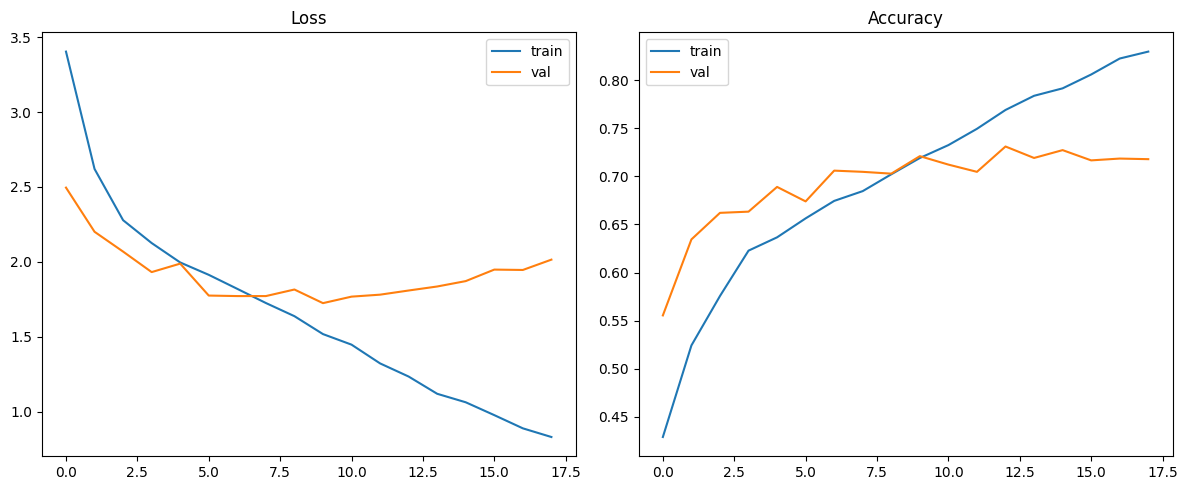

In [7]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(history["train_loss"], label="train")
ax[0].plot(history["val_loss"], label="val")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(history["train_acc"], label="train")
ax[1].plot(history["val_acc"], label="val")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.tight_layout()
plt.show()

# Performance on the validation split

In [9]:
from src.inference.predict import gather_predictions, gather_predictions_tta
from src.inference.metrics import compute_metrics, plot_metrics
from src.inference.predict import load_model
from src.data.dataset import ChestXRayTestDataset, TTADataset
from src.data.transforms import build_transforms, build_tta_transforms

# Load best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/chestxray-efficientnet/outputs/model/efficientnet_b4_best.safetensors"
model = load_model(model_path, model_type = "efficientnet_b4", num_classes=3, device=device)

## Without Test-Time-Augmentation:

              precision    recall  f1-score   support

           0       0.61      0.62      0.61       381
           1       0.68      0.71      0.70       351
           2       0.81      0.79      0.80       863

    accuracy                           0.73      1595
   macro avg       0.70      0.71      0.70      1595
weighted avg       0.73      0.73      0.73      1595



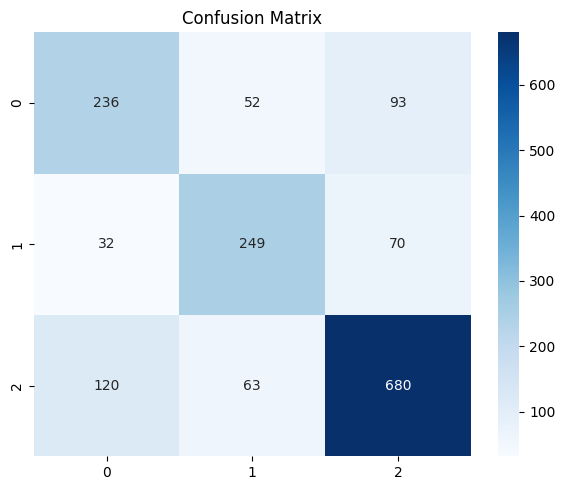

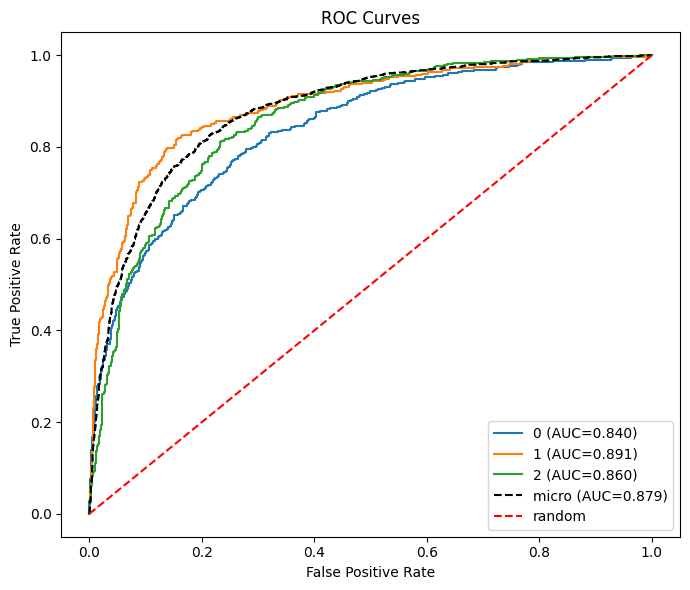

In [10]:
val_loader = DataLoader(
    val_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=False,
    num_workers=8,
    persistent_workers=True
)

all_labels, all_preds, all_probs = gather_predictions(
    model,
    val_loader,
    device
)

metrics = compute_metrics(
    all_labels,
    all_preds,
    all_probs,
    class_names=["0","1","2"]
)
print(metrics["classification_report"])

plot_metrics(
    metrics,
    class_names=["0","1","2"],
    save_dir = "assets/figures/val"
)

## With Test-Time-Augmentation

              precision    recall  f1-score   support

           0       0.62      0.61      0.61       381
           1       0.68      0.72      0.70       351
           2       0.80      0.79      0.79       863

    accuracy                           0.73      1595
   macro avg       0.70      0.71      0.70      1595
weighted avg       0.73      0.73      0.73      1595



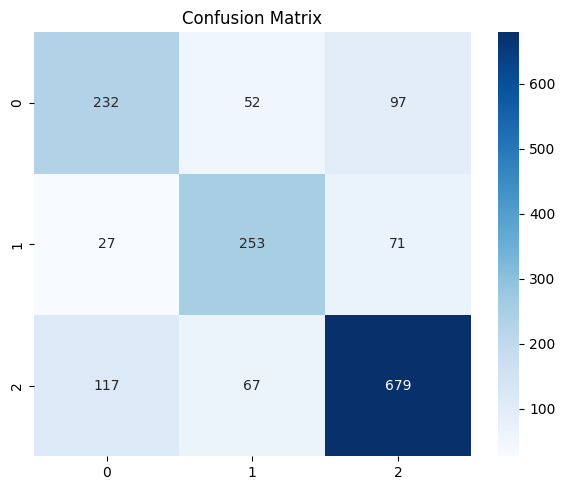

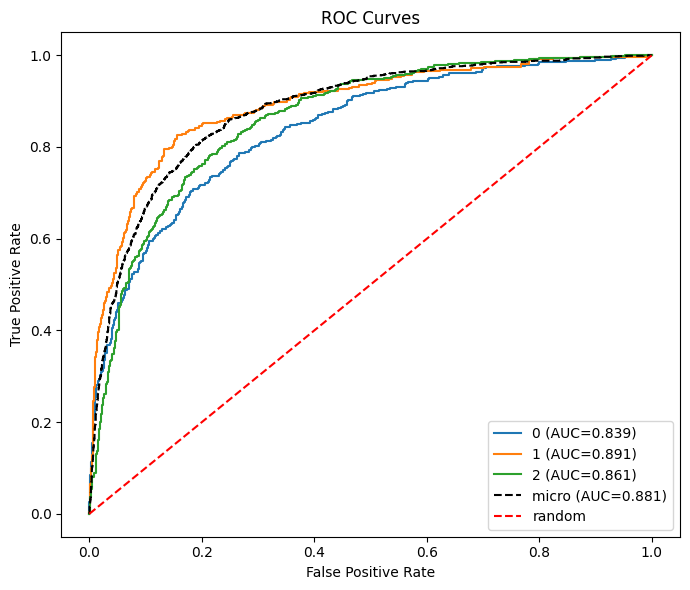

In [11]:
tta_transforms = build_tta_transforms(cfg_data["img_size"])

tta_val_dataset = TTADataset(
    val_df,
    cfg_data["train_dir"],
    tta_transforms
)

tta_val_loader = DataLoader(
    tta_val_dataset,
    batch_size=cfg_data["batch_size"],
    shuffle=False,
    num_workers= 8,
    pin_memory=True
)

val_labels_tta, val_preds_tta, val_probs_tta = gather_predictions_tta(
    model,
    tta_val_loader,
    device
)

metrics_tta = compute_metrics(
    val_labels_tta,
    val_preds_tta,
    val_probs_tta,
    class_names=["0","1","2"]
)
print(metrics_tta["classification_report"])

plot_metrics(
    metrics_tta,
    class_names=["0","1","2"],
    save_dir = "assets/figures/val_tta"
)

# Inference

In [14]:
import pandas as pd
from src.inference.predict import load_model, gather_predictions_no_labels, gather_predictions_tta_no_labels
from src.data.dataset import ChestXRayTestDataset, TTATestDataset
from src.data.transforms import build_transforms, build_tta_transforms

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/chestxray-efficientnet/outputs/model/efficientnet_b4_best.safetensors"
model = load_model(model_path,model_type = "efficientnet_b4", num_classes=3, device=device)

In [15]:
# Build transforms for inference
tfms = build_transforms(img_size=cfg_data["img_size"])["val"]

# Dataset
test_dataset = ChestXRayTestDataset(image_dir=cfg_data["test_dir"], transform=tfms)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=False,
    num_workers=8,
    persistent_workers=True
)

all_paths, all_preds, all_probs = gather_predictions_no_labels(
    model,
    test_dataloader,
    device
)

save_to = "assets/example_predictions/predictions.csv"
df_test = pd.DataFrame({
    "path": all_paths,
    "label": all_preds,
    "prob0": all_probs[:,0],
    "prob1": all_probs[:,1],
    "prob2": all_probs[:,2]
})
df_test.to_csv(save_to)

In [16]:
# Build transforms for inference
tfms_tta = build_tta_transforms(img_size=cfg_data["img_size"])

# Dataset
test_tta_dataset = TTATestDataset(image_dir=cfg_data["test_dir"], transforms_list=tfms_tta)

test_tta_dataloader = DataLoader(
    test_tta_dataset,
    batch_size=cfg["data"]["batch_size"],
    shuffle=False,
    num_workers=8,
    persistent_workers=True
)

all_paths_tta, all_preds_tta, all_probs_tta = gather_predictions_tta_no_labels(
    model,
    test_tta_dataloader,
    device
)

save_to = "assets/example_predictions/predictions_tta.csv"
df_test_tta = pd.DataFrame({
    "path": all_paths_tta,
    "label": all_preds_tta,
    "prob0": all_probs_tta[:,0],
    "prob1": all_probs_tta[:,1],
    "prob2": all_probs_tta[:,2]
})
df_test_tta.to_csv(save_to)